In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.signal import butter, lfilter, filtfilt, welch, stft, iirnotch, freqz
from scipy.fft import fft, fftfreq
from sklearn.decomposition import FastICA
import pywt

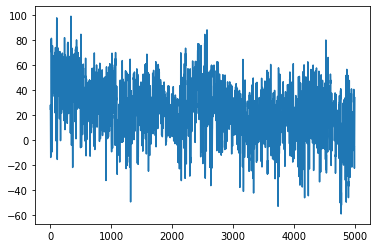

In [2]:
## Loading Data

# Channel Names
n = ['EMG', 'EKG', 'Fp1', 'Fp2', 'A2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
     'T4', 'T5', 'P3', 'Pz', 'P4', 'O1', 'O2', 'T1', 'T2', 'PG1', 'PG2', 'A1', 'T6', 'MK']

# Alzheimer's Data
alz_df = []
path = r'/Users/atharvadeshmukh/Desktop/Miniproject_python/alz_csv/'
all_files = glob.glob(os.path.join(path, "*.csv"))
for f in all_files:
    alz_df.append(pd.read_csv(f, names=n))

# Migraine Data
mig_df = []
path = r'/Users/atharvadeshmukh/Desktop/Miniproject_python/mig_csv/'
all_files = glob.glob(os.path.join(path, "*.csv"))
for f in all_files:
    mig_df.append(pd.read_csv(f, names=n))

# Seizure Data
sei_df = []
path = r'/Users/atharvadeshmukh/Desktop/Miniproject_python/seiz_csv/'
all_files = glob.glob(os.path.join(path, "*.csv"))
for f in all_files:
    sei_df.append(pd.read_csv(f, names=n))

# Normal Data
nor_df = []
path = r'/Users/atharvadeshmukh/Desktop/Miniproject_python/nor_csv/'
all_files = glob.glob(os.path.join(path, "*.csv"))
for f in all_files:
    nor_df.append(pd.read_csv(f, names=n))

del all_files
del f
del path

#plt.plot(alz_df[1]['O1'][0:5000])

In [3]:
### 6th Order Butterworth filter

def butter_bandpass(lowcut, highcut, fs=128, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=128, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(data):
    out = butter_bandpass_filter(data, 0.5, 60)
    return out

alz_nois = bandpass_filter(nor_df[2])

### NOTCH FILTER
    
def notch_filter(data):
    b,a = iirnotch(50, 30, fs=128)
    y = filtfilt(b, a, data)
    return y

alz_nois = notch_filter(alz_nois)

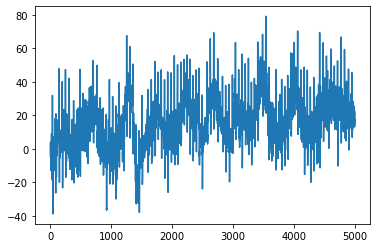

In [6]:
### NOISE FILTERING ALL DATA

alz_n = []
for i in range(14):
    x = bandpass_filter(alz_df[i])
    y = notch_filter(x)
    alz_n.append(y)

nor_n = []
for i in range(3):
    x = bandpass_filter(nor_df[i])
    y = notch_filter(x)
    nor_n.append(y)

mig_n = []
for i in range(13):
    x = bandpass_filter(mig_df[i])
    y = notch_filter(x)
    mig_n.append(y)

sei_n = []
for i in range(10):
    x = bandpass_filter(sei_df[i])
    y = notch_filter(x)
    sei_n.append(y)


plt.plot(alz_n[1][:,19][0:5000])

In [7]:
### SEGMENTATION
def segment_fn(data, fs=128, size=60):
    sgmt_data = []
    sgmt = fs*size
    while(len(data) > sgmt):
        x = data[:sgmt]
        sgmt_data.append(x)
        data = data[sgmt:len(data)]
    return sgmt_data

alz_sg = []
for i in range(14):
    x = segment_fn(alz_n[i])
    alz_sg.append(x)

mig_sg = []
for i in range(13):
    x = segment_fn(mig_n[i])
    mig_sg.append(x)

sei_sg = []
for i in range(10):
    x = segment_fn(sei_n[i])
    sei_sg.append(x)

nor_sg = []
for i in range(3):
    x = segment_fn(nor_n[i])
    nor_sg.append(x)

### TAKING 4 SEGMENTS FROM THE MIDDLE
alz_s = []
nor_s = []
mig_s = []
sei_s = []

for i in range(14):
    if i==8: continue
    alz_sg = segment_fn(alz_n[i])
    alz_sg = alz_sg[8:12]
    final_alz = [*alz_sg[0], *alz_sg[1]]
    final_alz = [*final_alz, *alz_sg[2]]
    final_alz = [*final_alz, *alz_sg[3]]
    #final_alz = alz_sg[0].append(alz_sg[1]).append(alz_sg[2]).append(alz_sg[3])
    alz_s.append(final_alz)

for i in range(3):
    nor_sg = segment_fn(nor_n[i])
    nor_sg = nor_sg[8:12]
    final_nor = [*nor_sg[0], *nor_sg[1]]
    final_nor = [*final_nor, *nor_sg[2]]
    final_nor = [*final_nor, *nor_sg[3]]
    #final_nor = nor_sg[0].append(nor_sg[1]).append(nor_sg[2]).append(nor_sg[3])
    nor_s.append(final_nor)

for i in range(13):
    mig_sg = segment_fn(mig_n[i])
    mig_sg = mig_sg[9:13]
    final_mig = [*mig_sg[0], *mig_sg[1]]
    final_mig = [*final_mig, *mig_sg[2]]
    final_mig = [*final_mig, *mig_sg[3]]
    #final_mig = mig_sg[0].append(mig_sg[1]).append(mig_sg[2]).append(mig_sg[3])
    mig_s.append(final_mig)

for i in range(10):
    sei_sg = segment_fn(sei_n[i])
    sei_sg = sei_sg[9:13]
    final_sei = [*sei_sg[0], *sei_sg[1]]
    final_sei = [*final_sei, *sei_sg[2]]
    final_sei = [*final_sei, *sei_sg[3]]
    #final_sei = sei_sg[0].append(sei_sg[1]).append(sei_sg[2]).append(sei_sg[3])
    sei_s.append(final_sei)


In [21]:
'''
### FUNCTION TO TAKE MIDDLE 4 SEGMENTS

def mid_seg(data):
    data = data[8:12]
    x = data[0].append(data[1]).append(data[2]).append(data[3])
    return x


alz_s = []
for i in range(15):
    data = alz_sg[i]
    data = data[8:12]
    x = data[0].append(data[1]).append(data[2]).append(data[3])
    alz_s.append(x)

mig_s = []
for i in range(13):
    x = mid_seg(mig_sg[i])
    mig_s.append(x)

sei_s = []
for i in range(10):
    x = mid_seg(sei_sg[i])
    sei_s.append(x)

nor_s = []
for i in range(3):
    x = mid_seg(nor_sg[i])
    nor_s.append(x)
'''

'\n### FUNCTION TO TAKE MIDDLE 4 SEGMENTS\n\ndef mid_seg(data):\n    data = data[8:12]\n    x = data[0].append(data[1]).append(data[2]).append(data[3])\n    return x\n\n\nalz_s = []\nfor i in range(15):\n    data = alz_sg[i]\n    data = data[8:12]\n    x = data[0].append(data[1]).append(data[2]).append(data[3])\n    alz_s.append(x)\n\nmig_s = []\nfor i in range(13):\n    x = mid_seg(mig_sg[i])\n    mig_s.append(x)\n\nsei_s = []\nfor i in range(10):\n    x = mid_seg(sei_sg[i])\n    sei_s.append(x)\n\nnor_s = []\nfor i in range(3):\n    x = mid_seg(nor_sg[i])\n    nor_s.append(x)\n'

In [8]:
### FEATURES USING DWT cA5 cD5 cD4 cD3 cD2 cD1
def wavelet_fn(data):
    coeffs = pywt.wavedec(data, 'db4', level=5)
    delta, theta, alpha, beta, gamma, noise = coeffs
    wt = pywt.waverec(coeffs, 'db4')
    return wt

alz_wt = []
for i in range(13):
    x = wavelet_fn(alz_s[i])
    alz_wt.append(x)

mig_wt = []
for i in range(13):
    x = wavelet_fn(mig_s[i])
    mig_wt.append(x)

sei_wt = []
for i in range(10):
    x = wavelet_fn(sei_s[i])
    sei_wt.append(x)

nor_wt = []
for i in range(3):
    x = wavelet_fn(nor_s[i])
    nor_wt.append(x)


'''
alz_psd = wavelet_fn(final_alz)
nor_psd = wavelet_fn(final_nor)
'''

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


'\nalz_psd = wavelet_fn(final_alz)\nnor_psd = wavelet_fn(final_nor)\n'

In [10]:

## BANDPASS FILTER

def butter_bandpass(lowcut, highcut, fs=128, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=128, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def bandpass_filter(data, l, h):
    out = butter_bandpass_filter(data, l, h)
    return out

def sub_bands(data):
    delta = bandpass_filter(data, 0.5, 3.5)
    theta = bandpass_filter(data, 4, 7.5)
    alpha = bandpass_filter(data, 8, 13.5)
    beta = bandpass_filter(data, 14, 36.5)
    gamma = bandpass_filter(data, 37, 49.5)
    return [delta, theta, alpha, beta, gamma]





In [ ]:
'''
### FOR DEMONSTATON
alz_psd = wavelet_fn(alz_s[1])
nor_psd = wavelet_fn(nor_s[1])


alz_delta = bandpass_filter(alz_psd, 0.5, 3.5)
alz_theta = bandpass_filter(alz_psd, 4, 7.5)
alz_alpha = bandpass_filter(alz_psd, 8, 13.5)
alz_beta = bandpass_filter(alz_psd, 14, 36.5)
alz_gamma = bandpass_filter(alz_psd, 37, 49.5)

nor_delta = bandpass_filter(nor_psd, 0.5, 3.5)
nor_theta = bandpass_filter(nor_psd, 4, 7.5)
nor_alpha = bandpass_filter(nor_psd, 8, 13.5)
nor_beta = bandpass_filter(nor_psd, 14, 36.5)
nor_gamma = bandpass_filter(nor_psd, 37, 49.5)
'''

In [46]:
'''
alz_sb = []
for i in range(13):
    x = sub_bands(alz_wt[i])
    alz_sb.append(x)

mig_sb = []
for i in range(13):
    x = sub_bands(mig_wt[i])
    mig_sb.append(x)

sei_sb = []
for i in range(10):
    x = sub_bands(sei_wt[i])
    sei_sb.append(x)

nor_sb = []
for i in range(3):
    x = sub_bands(nor_wt[i])
    nor_sb.append(x)
'''

'\nalz_sb = []\nfor i in range(13):\n    x = sub_bands(alz_wt[i])\n    alz_sb.append(x)\n\nmig_sb = []\nfor i in range(13):\n    x = sub_bands(mig_wt[i])\n    mig_sb.append(x)\n\nsei_sb = []\nfor i in range(10):\n    x = sub_bands(sei_wt[i])\n    sei_sb.append(x)\n\nnor_sb = []\nfor i in range(3):\n    x = sub_bands(nor_wt[i])\n    nor_sb.append(x)\n'

In [11]:
### MEAN

def mean_fn(data):
    x = np.mean(data, axis = 0)
    return x


x = mean_fn(alz_theta)
y = mean_fn(nor_theta)
a = mean_fn(alz_beta)
b = mean_fn(nor_beta)
c = mean_fn(alz_alpha)
d = mean_fn(nor_alpha)
e = mean_fn(alz_delta)
f = mean_fn(nor_delta)
g = mean_fn(alz_gamma)
h = mean_fn(nor_gamma)

print("ALZHEIMERS THETA")
print(x)
print("NORMAL THETA")
print(y)
print("ALZHEIMERS BETA")
print(a)
print("NORMAL BETA")
print(b)
print("ALZHEIMERS ALPHA")
print(c)
print("NORMAL ALPHA")
print(d)
print("ALZHEIMERS DELTA")
print(e)
print("NORMAL DELTA")
print(f)
print("ALZHEIMERS GAMMA")
print(g)
print("NORMAL GAMMA")
print(h)

ALZHEIMERS THETA
[-9.46933462e-07 -1.51398086e-05 -1.10620646e-04 -5.06783534e-04
 -1.67123377e-03 -4.29510727e-03 -9.04807950e-03 -1.61308947e-02
 -2.47650665e-02 -3.28391714e-02 -3.69485915e-02 -3.29753093e-02
 -1.71459893e-02  1.27100088e-02  5.60594925e-02  1.09006916e-01
  1.64246269e-01  2.11693714e-01  2.39781553e-01  2.37283588e-01
  1.95431029e-01  1.10000625e-01 -1.69966790e-02 -1.76420374e-01
 -3.52219076e-01 -5.22875288e-01 -6.63911071e-01 -7.51058119e-01]
NORMAL THETA
[-2.89361828e-06 -3.38110750e-05 -1.90378999e-04 -6.94350595e-04
 -1.86136256e-03 -3.93982840e-03 -6.87481679e-03 -1.01024601e-02
 -1.24610886e-02 -1.22919263e-02 -7.77303363e-03  2.55916619e-03
  1.92341665e-02  4.13707206e-02  6.64170447e-02  9.01772805e-02
  1.07164092e-01  1.11297188e-01  9.69134233e-02  5.99563691e-02
 -8.71345949e-04 -8.32164134e-02 -1.80610508e-01 -2.82549349e-01
 -3.75208777e-01 -4.42852628e-01 -4.69877294e-01 -4.43245063e-01]
ALZHEIMERS BETA
[-0.01803173 -0.14473989 -0.27973826  0.37

In [12]:
# VARIANCE

def var_fn(data):
    x = np.var(data, axis = 0)
    return x

x = var_fn(alz_theta)
y = var_fn(nor_theta)
a = var_fn(alz_beta)
b = var_fn(nor_beta)
c = var_fn(alz_alpha)
d = var_fn(nor_alpha)
e = var_fn(nor_delta)
f = var_fn(nor_delta)
g = var_fn(nor_gamma)
h = var_fn(nor_gamma)


print("ALZHEIMERS THETA")
print(x)
print("NORMAL THETA")
print(y)
print("ALZHEIMERS BETA")
print(a)
print("NORMAL BETA")
print(b)
print("ALZHEIMERS ALPHA")
print(c)
print("NORMAL ALPHA")
print(d)
print("ALZHEIMERS DELTA")
print(e)
print("NORMAL DELTA")
print(f)
print("ALZHEIMERS GAMMA")
print(g)
print("NORMAL GAMMA")
print(h)

ALZHEIMERS THETA
[5.41139692e-11 8.11382255e-09 3.25210951e-07 5.89170061e-06
 5.86461186e-05 3.59761433e-04 1.47598715e-03 4.28798205e-03
 9.11488679e-03 1.42405956e-02 1.57825130e-02 1.14130886e-02
 7.63180025e-03 2.49900884e-02 9.27751886e-02 2.29388584e-01
 4.16941452e-01 5.90513060e-01 6.62360429e-01 5.82814399e-01
 4.09686677e-01 3.36417641e-01 6.36557642e-01 1.52419524e+00
 2.98882129e+00 4.70363816e+00 6.09517972e+00 6.59053194e+00]
NORMAL THETA
[4.76813455e-08 6.38722549e-06 2.00276195e-04 2.65807982e-03
 1.92239795e-02 8.73767748e-02 2.72444668e-01 6.13075113e-01
 1.01509973e+00 1.22113332e+00 1.03910649e+00 8.35783714e-01
 1.93670575e+00 6.35250449e+00 1.55390025e+01 2.87050619e+01
 4.19895092e+01 4.98591671e+01 4.89093037e+01 4.23275034e+01
 4.18756900e+01 6.46703762e+01 1.24666212e+02 2.22448503e+02
 3.39483951e+02 4.42256120e+02 4.97189512e+02 4.90768554e+02]
ALZHEIMERS BETA
[1.96220894e-02 5.04525539e-01 2.77824847e+00 8.61554308e+00
 9.68077238e+01 7.71636479e+01 4.7239

In [13]:
# STANDARD DEVIATION

def std_fn(data):
    x = np.std(data, axis = 0)
    return x

x = std_fn(alz_theta)
y = std_fn(nor_theta)
a = std_fn(alz_beta)
b = std_fn(nor_beta)
c = std_fn(alz_alpha)
d = std_fn(nor_alpha)
e = std_fn(nor_delta)
f = std_fn(nor_delta)
g = std_fn(nor_gamma)
h = std_fn(nor_gamma)

print("ALZHEIMERS THETA")
print(x)
print("NORMAL THETA")
print(y)
print("ALZHEIMERS BETA")
print(a)
print("NORMAL BETA")
print(b)
print("ALZHEIMERS ALPHA")
print(c)
print("NORMAL ALPHA")
print(d)
print("ALZHEIMERS DELTA")
print(e)
print("NORMAL DELTA")
print(f)
print("ALZHEIMERS GAMMA")
print(g)
print("NORMAL GAMMA")
print(h)

ALZHEIMERS THETA
[7.35621976e-06 9.00767592e-05 5.70272699e-04 2.42728256e-03
 7.65807539e-03 1.89673781e-02 3.84185782e-02 6.54826852e-02
 9.54719162e-02 1.19333967e-01 1.25628472e-01 1.06832058e-01
 8.73601754e-02 1.58082537e-01 3.04590198e-01 4.78945283e-01
 6.45710037e-01 7.68448476e-01 8.13855287e-01 7.63422818e-01
 6.40067713e-01 5.80015207e-01 7.97845625e-01 1.23458302e+00
 1.72882078e+00 2.16878726e+00 2.46884178e+00 2.56720314e+00]
NORMAL THETA
[2.18360586e-04 2.52729608e-03 1.41518972e-02 5.15565691e-02
 1.38650566e-01 2.95595627e-01 5.21962324e-01 7.82991132e-01
 1.00752158e+00 1.10504901e+00 1.01936573e+00 9.14212073e-01
 1.39165576e+00 2.52041752e+00 3.94195415e+00 5.35771051e+00
 6.47993127e+00 7.06110240e+00 6.99351869e+00 6.50595907e+00
 6.47114286e+00 8.04178937e+00 1.11654024e+01 1.49147076e+01
 1.84250902e+01 2.10298864e+01 2.22977468e+01 2.21532967e+01]
ALZHEIMERS BETA
[ 0.14007887  0.71029961  1.66680787  2.93522454  9.83909161  8.78428414
 21.73458822 29.19019131 

In [14]:
# SKEWNESS
from scipy.stats import kurtosis, skew
def skew_fn(data):
    x = skew(data, axis = 0)
    return x

x = skew_fn(alz_theta)
y = skew_fn(nor_theta)
a = skew_fn(alz_beta)
b = skew_fn(nor_beta)
c = skew_fn(alz_alpha)
d = skew_fn(nor_alpha)
e = skew_fn(nor_delta)
f = skew_fn(nor_delta)
g = skew_fn(nor_gamma)
h = skew_fn(nor_gamma)
print("ALZHEIMERS THETA")
print(x)
print("NORMAL THETA")
print(y)
print("ALZHEIMERS BETA")
print(a)
print("NORMAL BETA")
print(b)
print("ALZHEIMERS ALPHA")
print(c)
print("NORMAL ALPHA")
print(d)
print("ALZHEIMERS DELTA")
print(e)
print("NORMAL DELTA")
print(f)
print("ALZHEIMERS GAMMA")
print(g)
print("NORMAL GAMMA")
print(h)

ALZHEIMERS THETA
[-0.36936479 -0.37100276 -0.42695285 -0.52918667 -0.62971204 -0.7067973
 -0.7590335  -0.78972509 -0.7991891  -0.77847299 -0.68996334 -0.38171658
  0.18716173  0.51212902  0.78362966  0.86083031  0.86972638  0.83611914
  0.74747802  0.55158228  0.16013603 -0.12891348 -0.35205006 -0.69321653
 -0.84261144 -0.88392111 -0.86341716 -0.7849921 ]
NORMAL THETA
[ 0.65020172  0.65245394  0.65144843  0.64386219  0.62387989  0.58180424
  0.50091689  0.3488707   0.0522683  -0.58468273 -2.07858377 -3.40292346
 -1.10220469 -0.97439493 -0.99368834 -0.85704075 -0.54921912  0.02971972
  1.10229339  2.76746814  3.32911822  1.70688115  1.01893966  0.98339305
  0.95859436  0.77582966  0.33001743 -0.54392493]
ALZHEIMERS BETA
[-3.69364787e-01 -5.40861076e-01 -9.89736287e-01  3.90450115e-01
  9.76493537e-01  3.57487783e-01 -8.59345767e-01 -9.89383681e-01
  5.39114068e-01  1.00307016e+00  3.51540471e-01 -7.92901464e-01
 -7.55759631e-01  4.70933596e-01  1.79868132e-01 -6.56113000e-02
  2.9726671

In [15]:
# KURTOSIS 

def kurt_fn(data):
    x = kurtosis(data, axis = 0)
    return x

x = kurt_fn(alz_theta)
y = kurt_fn(nor_theta)
a = kurt_fn(alz_beta)
b = kurt_fn(nor_beta)
c = kurt_fn(alz_alpha)
d = kurt_fn(nor_alpha)
e = kurt_fn(nor_delta)
f = kurt_fn(nor_delta)
g = kurt_fn(nor_gamma)
h = kurt_fn(nor_gamma)
print("ALZHEIMERS THETA")
print(x)
print("NORMAL THETA")
print(y)
print("ALZHEIMERS BETA")
print(a)
print("NORMAL BETA")
print(b)
print("ALZHEIMERS ALPHA")
print(c)
print("NORMAL ALPHA")
print(d)
print("ALZHEIMERS DELTA")
print(e)
print("NORMAL DELTA")
print(f)
print("ALZHEIMERS GAMMA")
print(g)
print("NORMAL GAMMA")
print(h)

ALZHEIMERS THETA
[ 0.76219063  0.69980168  0.83414714  1.30875516  1.88399221  2.37941021
  2.75039024  3.00504316  3.14846103  3.14474645  2.82635034  1.56753742
 -0.09613875  1.18548041  2.73005192  3.30229565  3.47580768  3.40996103
  3.06374399  2.21998269  0.65533225 -0.17906457  0.57098463  2.23870889
  3.16089278  3.51560668  3.52431205  3.21976327]
NORMAL THETA
[10.16078192 10.17173979 10.19309466 10.22186344 10.24529939 10.24127453
 10.18473291 10.0656089   9.96088626 10.44262637 14.9509794  22.56040593
  6.19835401  9.55457453 10.79235105 10.45193333  9.58018263  8.92165245
 10.40113771 18.09080515 21.85252866  8.54546822  7.3880609   9.78096838
 10.36400699  9.47087449  8.08809154  8.07992717]
ALZHEIMERS BETA
[ 0.76219063  1.35722002  4.46171919  0.77707454  4.13724328  1.66821891
  3.24225214  4.38993233  1.29739351  4.34009138  1.26621169  3.00347256
  2.78056446  0.21461575  1.30519547  0.66163285  1.47189969  1.43553357
  1.36504101  0.70375713  2.90962799  2.01772842 19